<a href="https://colab.research.google.com/github/EduPras/4LINUX/blob/master/notebooks/SINKT_Base_Sint%C3%A9tica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title # Setup code
# In order to reduce notebook size and have a modular code, I implemented using modules.
!git clone https://github.com/EduPras/4LINUX.git

import os
import sys
from pathlib import Path

project_root = Path.cwd().parent / 'content'/'4LINUX'
sys.path.append(str(project_root))

# Simulação de estudantes + Perfis Cognitivos + Treino sintético do SINKT

## Perfis Cognitivos

Os perfis podem ser encontrados no módulo ``SINKT.student``. São 6 perfis:
- **Esforçado**: Mediano, porém persistente, aprende de forma constante.
- **Expert**: Já possui um conhecimento inicial grande, acerta muito, aprende rápido.
- **Lutador**:  Aprende devagar, erra muito e possui baixo conhecimento inicial
- **Analista**: Cuidadoso, aprendizado não tão rápido mas preciso.
- **Descuidado/Apressado**: Rápido, chuta bastante, porém aprende pouco.
- **Instável**: Às vezes bom, às vezes não.


## Simução e geração dos dados

Seguindo a lógica da implementação realizada na primeira fase do projeto, a GRU, os dados sintéticos foram gerados de forma probabilística, utilizando os perfis definidos anteriormente. Os parâmetros que diferenciam entre cada perfil são: ``slip_rate``, ``technological_familiarity``, ``guess_rate``, ``learning_speed``, ``logical_ability``, ``text_interpretation`` e ``initial_proficiency``. Como as imagens abaixo demonstram, o expert possui maior sucesso de acerto, porém sua maestria aumenta menos em relação aos outros (visto que já sabe muito). Isso é provado no último grafo, demonstrando que o mesmo arquétipo é o que mais possui conceitos desbloqueados.


![](https://github.com/EduPras/4LINUX/blob/master/notebooks/imgs/SINKT-synthetic-ds-1.png?raw=1)

![](https://github.com/EduPras/4LINUX/blob/master/notebooks/imgs/SINKT-synthetic-ds-2.png?raw=1)

![](https://github.com/EduPras/4LINUX/blob/master/notebooks/imgs/SINKT-synthetic-ds-3.png?raw=1)

In [ ]:
# import os
# import sys
# from pathlib import Path

# project_root = Path.cwd().parent  # Adjust as needed
# sys.path.append(str(project_root))

import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from langsmith.wrappers import wrap_openai
from openai import OpenAI

from SINKT.graph.builder import GraphXMLBuilder
from SINKT.student import StudentFactory
from SINKT.population import PopulationSimulator

load_dotenv('../.env')

# Put harcoded in case using colab
assert os.getenv("OPENAI_API_KEY"), "OPENAI_API_KEY not found"
assert os.getenv("ANTHROPIC_API_KEY"), "ANTHROPIC_API_KEY not found"
assert os.getenv("LANGSMITH_API_KEY"), "ANTHROPIC_API_KEY not found"
client = wrap_openai(OpenAI())

In [ ]:
from tqdm.notebook import tqdm

def generate_synthetic_dataset(n_students=10):
    xml_builder = GraphXMLBuilder()
    input_path = Path("../")

    if not input_path.exists():
        print("Data path not found.")
        return None

    kg_model = xml_builder.load(input_path)
    sim = PopulationSimulator(kg_model)

    all_data = []

    for i in tqdm(range(1, n_students + 1), desc='Creating students'):
        profile = StudentFactory.create_student(i)

        # Random sequence length (30-60 interactions)
        # n_steps = random.randint(30, 60)
        n_steps = 80

        student_history = sim.run_student_session(profile, n_steps, explain_error=False)
        all_data.extend(student_history)

    df = pd.DataFrame(all_data)
    return df, kg_model

In [ ]:
df_population, kg_model = generate_synthetic_dataset(n_students=500)

if df_population is not None:
    df_population.to_csv("synthetic_student_population.csv", index=False)
    print("Saved to synthetic_student_population.csv")

Creating students:   0%|          | 0/500 [00:00<?, ?it/s]

Saved to synthetic_student_population.csv


In [ ]:
archetype_counts = df_population.groupby(['student_id', 'archetype']).size().reset_index().groupby('archetype')['student_id'].nunique()
print("Number of students per archetype:")
for archetype, count in archetype_counts.items():
    print(f"{archetype}: {count}")

Number of students per archetype:
analyst: 97
dedicated: 70
expert: 85
hurry: 81
struggler: 84
unstable: 83


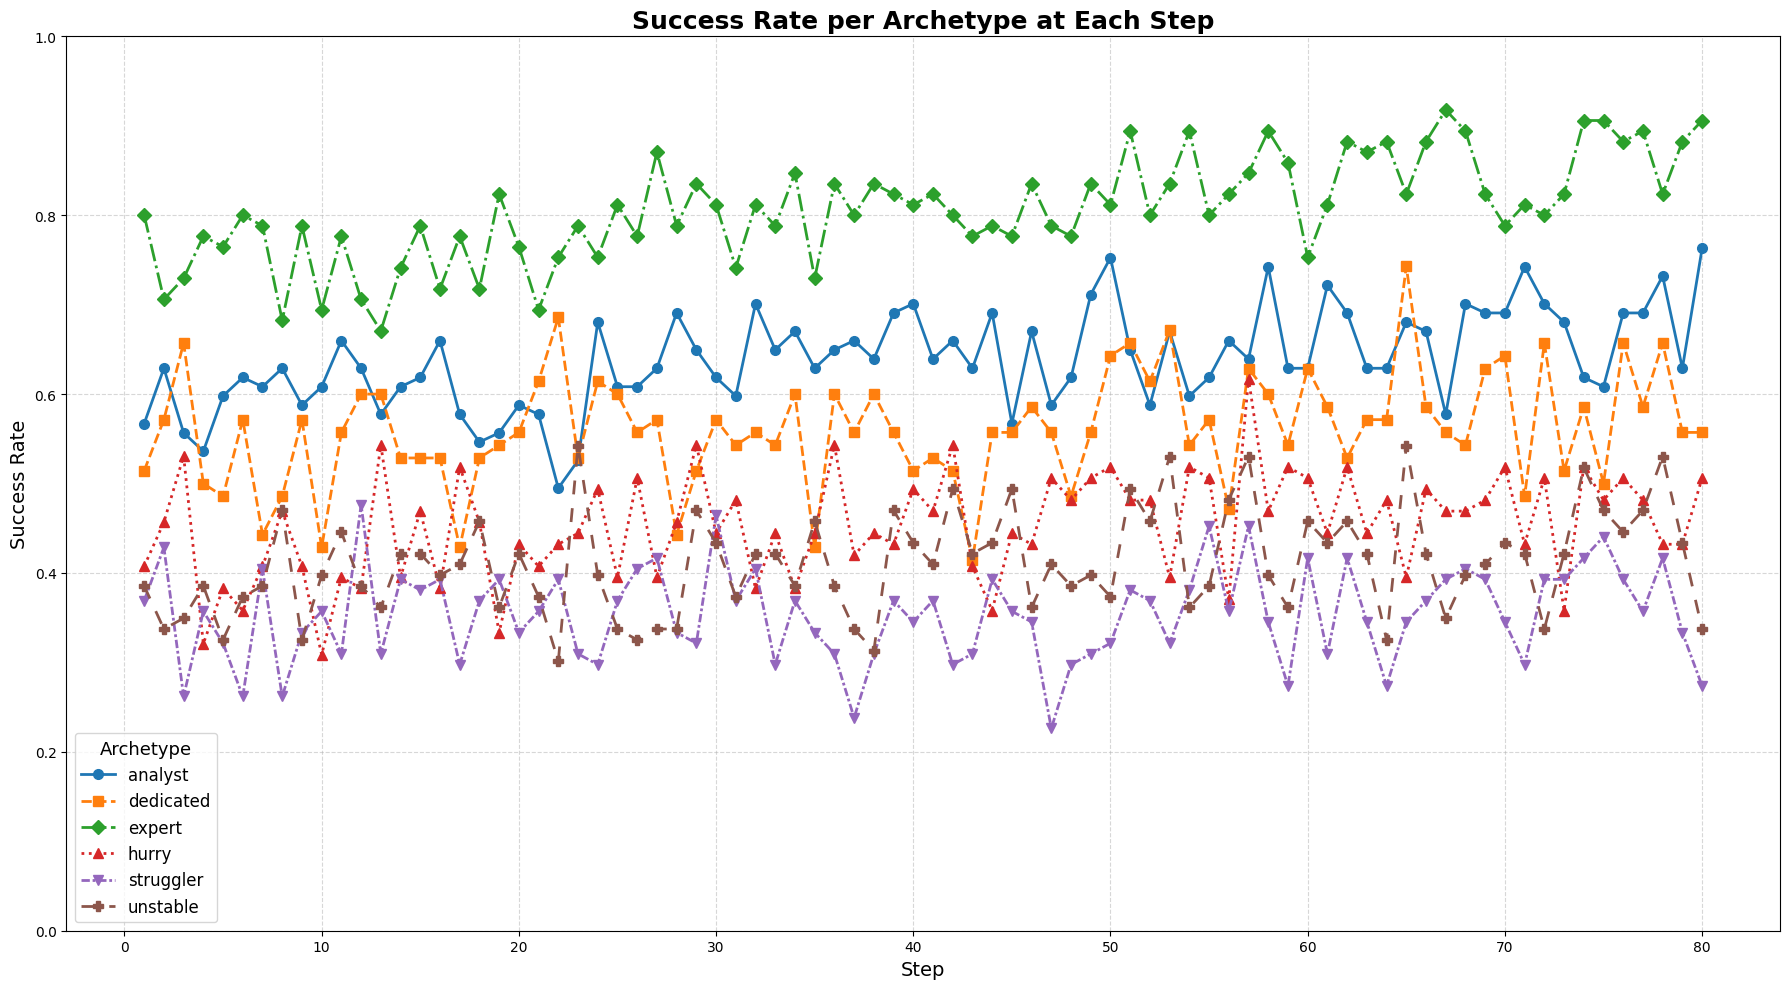

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Group by step and archetype, calculate mean (success rate)
success_rate = df_population.groupby(['step', 'archetype'])['outcome'].mean().reset_index()

plt.figure(figsize=(18, 10))
# Define line styles and markers
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]
markers = ['o', 's', 'D', '^', 'v', 'P', 'X']
colors = sns.color_palette('tab10', n_colors=success_rate['archetype'].nunique())

for idx, (archetype, group) in enumerate(success_rate.groupby('archetype')):
    style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    color = colors[idx % len(colors)]
    plt.plot(group['step'], group['outcome'], label=archetype, linestyle=style, marker=marker, color=color, linewidth=2, markersize=7)

plt.title('Success Rate per Archetype at Each Step', fontsize=18, fontweight='bold')
plt.xlabel('Step', fontsize=14)
plt.ylabel('Success Rate', fontsize=14)
plt.ylim(0, 1)
plt.legend(title='Archetype', fontsize=12, title_fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

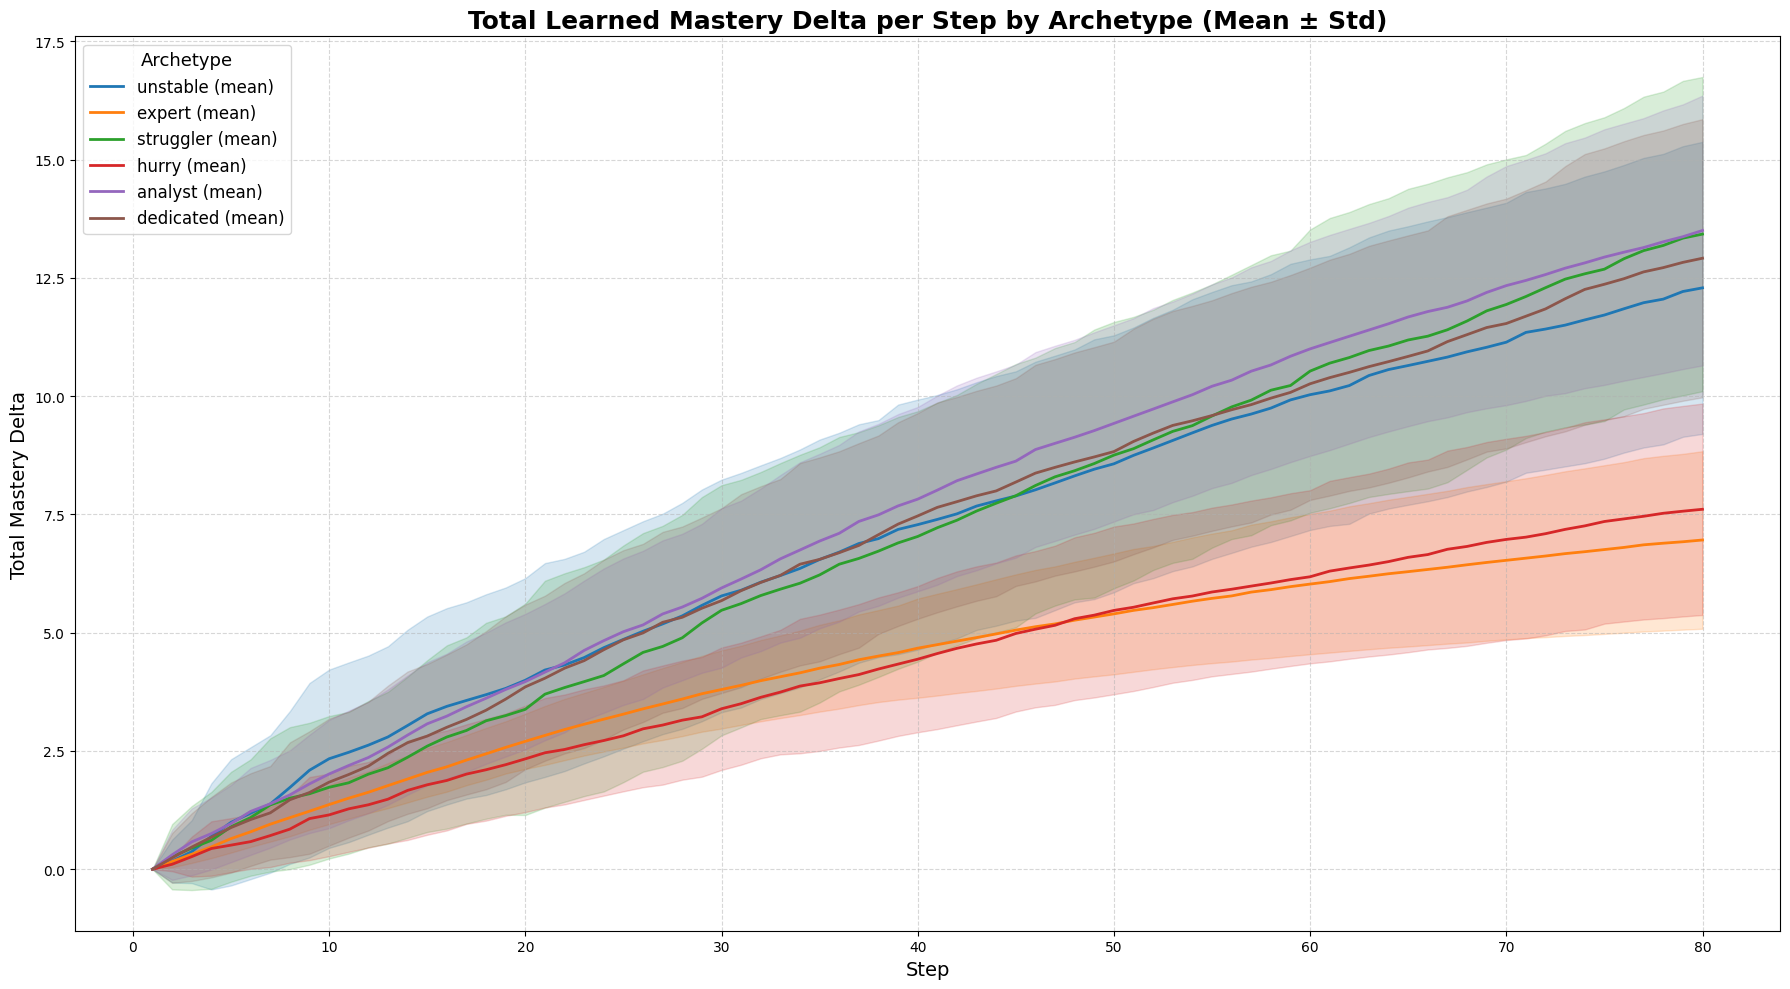

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

concept_cols = df_population.columns[15:]
step_mastery = df_population.groupby(['student_id', 'archetype', 'step'])[concept_cols].sum().reset_index()
step_mastery['total_mastery'] = step_mastery[concept_cols].sum(axis=1)
step_mastery['delta'] = step_mastery.groupby('student_id')['total_mastery'].transform(lambda x: x - x.iloc[0])

plt.figure(figsize=(18, 10)``)
archetypes = step_mastery['archetype'].unique()
colors = sns.color_palette('tab10', n_colors=len(archetypes))

for idx, archetype in enumerate(archetypes):
    data = step_mastery[step_mastery['archetype'] == archetype]
    delta_stats = data.groupby('step')['delta'].agg(['mean', 'std']).reset_index()
    plt.plot(delta_stats['step'], delta_stats['mean'], label=f'{archetype} (mean)', color=colors[idx], linewidth=2)
    plt.fill_between(delta_stats['step'],
                     delta_stats['mean'] - delta_stats['std'],
                     delta_stats['mean'] + delta_stats['std'],
                     color=colors[idx], alpha=0.18)

plt.title('Total Learned Mastery Delta per Step by Archetype (Mean ± Std)', fontsize=18, fontweight='bold')
plt.xlabel('Step', fontsize=14)
plt.ylabel('Total Mastery Delta', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(title='Archetype', fontsize=12, title_fontsize=13)
plt.show()

/tmp/ipykernel_17918/4126562170.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=archetype_mastered.index, y=archetype_mastered.values, palette='viridis')


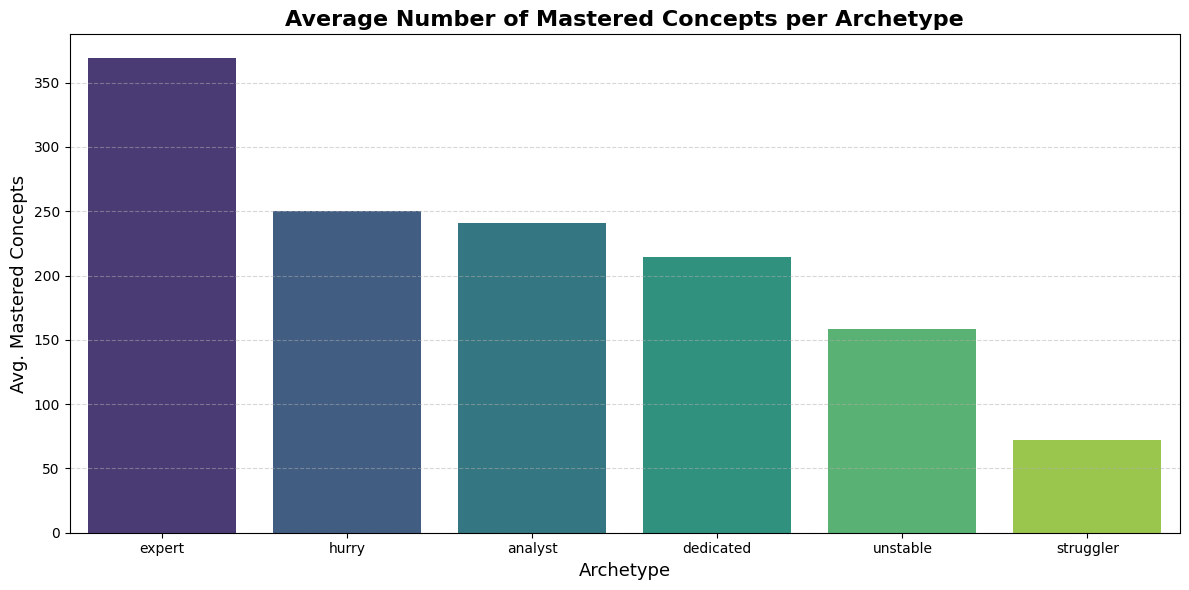

In [ ]:
# Plot the average number of mastered concepts per archetype (final mastery > 0.8)
import seaborn as sns
import matplotlib.pyplot as plt

concept_cols = df_population.columns[15:]
# For each student, get the final mastery for each concept
final_mastery = df_population.groupby(['student_id', 'archetype'])[concept_cols].agg(lambda x: x.iloc[-1]).reset_index()
# Count how many concepts each student mastered (mastery > 0.8)
final_mastery['mastered_count'] = (final_mastery[concept_cols] > 0.8).sum(axis=1)
# Average mastered concepts per archetype
archetype_mastered = final_mastery.groupby('archetype')['mastered_count'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=archetype_mastered.index, y=archetype_mastered.values, palette='viridis')
plt.title('Average Number of Mastered Concepts per Archetype', fontsize=16, fontweight='bold')
plt.xlabel('Archetype', fontsize=13)
plt.ylabel('Avg. Mastered Concepts', fontsize=13)
plt.ylim(0, None)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Trainamento SINKT

A integração com a GRU do SINKT e o treinamento não tiveram bons resultados, pelo contrário, o modelo está apenas chutando: Uma loss em torno de **0.69** significa predições 0.5 $$ln(0.5) = -0.69$$, isso vem diretamente da fórmula da BCELoss ([Binary Cross Entropy: Where To Use Log Loss In Model Monitoring](https://arize.com/blog-course/binary-cross-entropy-log-loss/)).

Foram testadas diversas arquiteturas:
1. Primeiramente uma mais simples, com uma projeção das features para a GRU: ``[Embedding, Raw_Floats] -> Linear (Projection) -> ReLU -> GRU``
2. Posteriormente foi substituído a projeção por um MLP: ``[Embedding, Raw_Floats] -> MLP -> GRU``
3. Por fim, foi testada um modelo que utilizou a estrutura do grafo a GNN, sendo um pouco mais próximo da implementação original do SINKT. Porém os mesmos resultados foram obtidos.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np
from typing import Dict

class StudentDataset(Dataset):
    def __init__(self, csv_path: str, question_to_idx: Dict[str, int], seq_len=20):
        self.seq_len = seq_len
        self.question_to_idx = question_to_idx

        self.df = pd.read_csv(csv_path)

        self.feature_cols = [c for c in self.df.columns if c not in
                             ['student_id', 'step', 'question_id', 'outcome', 'archetype', 'p_know_latent']]

        numeric_df = self.df[self.feature_cols].select_dtypes(include=[np.number])
        self.feature_cols = numeric_df.columns.tolist()

        self.num_features = len(self.feature_cols)

        # Group Data
        self.grouped_data = []
        for student_id, group in self.df.sort_values('step').groupby('student_id'):
            # Convert question IDs to integers using the Graph Map
            # Unknown questions map to 0 (or a specific UNK index if desired)
            q_ids = [self.question_to_idx.get(qid, 0) for qid in group['question_id'].values]

            feats = group[self.feature_cols].values.astype(float)
            target = group['outcome'].values.astype(float)

            self.grouped_data.append({
                'student_id': student_id,
                'q_seq': q_ids,
                'feat_seq': feats,
                'target_seq': target
            })

    def __len__(self):
        return len(self.grouped_data)

    def __getitem__(self, idx):
        data = self.grouped_data[idx]

        q = data['q_seq'][:self.seq_len]
        f = data['feat_seq'][:self.seq_len]
        t = data['target_seq'][:self.seq_len]

        return {
            'q_seq': torch.tensor(q, dtype=torch.long),
            'feat_seq': torch.tensor(f, dtype=torch.float),
            'target_seq': torch.tensor(t, dtype=torch.float)
        }

    @property
    def num_questions(self):
        return len(self.question_to_idx) + 1


In [ ]:
def collate_fn(batch):
    max_len = max([len(item['q_seq']) for item in batch])
    batch_size = len(batch)
    num_feats = batch[0]['feat_seq'].shape[1]

    q_batch = torch.zeros((batch_size, max_len), dtype=torch.long)
    target_batch = torch.zeros((batch_size, max_len), dtype=torch.float)
    feat_batch = torch.zeros((batch_size, max_len, num_feats), dtype=torch.float)
    mask_batch = torch.zeros((batch_size, max_len), dtype=torch.float)

    for i, item in enumerate(batch):
        length = len(item['q_seq'])
        q_batch[i, :length] = item['q_seq']
        target_batch[i, :length] = item['target_seq']
        feat_batch[i, :length] = item['feat_seq']
        mask_batch[i, :length] = 1.0

    return q_batch, feat_batch, target_batch, mask_batch

In [ ]:
from SINKT.graph.model import KnowledgeGraphModel
from typing import Tuple, Dict
from torch_geometric.data import HeteroData

def build_graph_data(knowledge_graph: KnowledgeGraphModel, embed_dim=16) -> Tuple[HeteroData, Dict[str, int]]:
    """
    Constructs the HeteroData object from the KnowledgeGraphModel.
    Returns: (HeteroData, question_to_idx_map)
    """

    # 1. Mappings
    concept_to_idx = {c.name: i for i, c in enumerate(knowledge_graph.concepts)}
    questions = knowledge_graph.questions if knowledge_graph.questions else []
    # Map specific_concept_id (from CSV/Question) to an Integer Index
    question_to_idx = {q.specific_concept_id: i + 1 for i, q in enumerate(questions)}


    num_concepts = len(knowledge_graph.concepts)
    num_questions = len(questions)

    # 2. HeteroData Construction
    data = HeteroData()
    # Initialize random embeddings
    data['concept'].x = torch.randn(num_concepts, embed_dim)
    data['question'].x = torch.randn(num_questions, embed_dim)

    # 3. Edges: Prerequisite (Concept -> Concept)
    sources, targets = [], []
    for rel in knowledge_graph.relations:
        if rel.source in concept_to_idx and rel.target in concept_to_idx:
            sources.append(concept_to_idx[rel.source])
            targets.append(concept_to_idx[rel.target])

    if sources:
        data['concept', 'prerequisite', 'concept'].edge_index = torch.stack(
            [torch.tensor(sources), torch.tensor(targets)], dim=0
        )
    else:
        data['concept', 'prerequisite', 'concept'].edge_index = torch.empty((2, 0), dtype=torch.long)

    # 4. Edges: Tested By (Concept -> Question)
    c_indices, q_indices = [], []
    for i, q in enumerate(questions):
        # Main Concept
        if q.main_concept_id in concept_to_idx:
            c_indices.append(concept_to_idx[q.main_concept_id])
            q_indices.append(i)
        # Specific Concept
        if q.specific_concept_id in concept_to_idx:
            c_indices.append(concept_to_idx[q.specific_concept_id])
            q_indices.append(i)

    if c_indices:
        data['concept', 'tested_by', 'question'].edge_index = torch.stack(
            [torch.tensor(c_indices), torch.tensor(q_indices)], dim=0
        )
    else:
        data['concept', 'tested_by', 'question'].edge_index = torch.empty((2, 0), dtype=torch.long)

    return data, question_to_idx

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv

class GraphEncoder(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # We use SAGEConv to aggregate info from neighbors
        self.conv1 = HeteroConv({
            ('concept', 'prerequisite', 'concept'): SAGEConv((-1, -1), hidden_channels),
            ('concept', 'tested_by', 'question'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('concept', 'prerequisite', 'concept'): SAGEConv((-1, -1), hidden_channels),
            ('concept', 'tested_by', 'question'): SAGEConv((-1, -1), hidden_channels),
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        # 1. Message Passing Layer 1
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # 2. Message Passing Layer 2
        x_dict = self.conv2(x_dict, edge_index_dict)
        # Apply ReLU at the end as requested
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}

        # Return ALL node embeddings. We specifically care about 'question'
        return x_dict


In [ ]:
import torch
import torch.nn as nn

class GRUKnowledgeTracer(nn.Module):
    def __init__(self, num_questions, num_features, embed_dim=16, hidden_dim=32, proj_dim=16, dropout_rate=0.2):
        super().__init__()
        self.num_questions = num_questions

        # 1. Graph Encoder
        self.gnn = GraphEncoder(embed_dim)

        # 2. Sequence Model
        # Input to GRU is: Question_Embedding (from GNN) + Auxiliary Features
        rnn_input_dim = embed_dim + num_features
        self.gru = nn.GRU(input_size=rnn_input_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

        # 3. Prediction Head
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, q_batch, feat_batch, graph_data):
        """
        q_batch: (Batch, Seq) - Indices of questions
        feat_batch: (Batch, Seq, Feats) - Auxiliary student features
        graph_data: HeteroData object containing the Knowledge Graph
        """
         # 1. GNN: Get embeddings for questions (Indices 0..N-1)
        node_embeddings = self.gnn(graph_data.x_dict, graph_data.edge_index_dict)
        raw_q_embeddings = node_embeddings['question']

        # 2. Add a specialized embedding for PADDING (Index 0)
        # We append a zero-vector to the top of the GNN output
        # So Index 0 -> Zero Vector, Index 1 -> GNN[0], Index 2 -> GNN[1]
        device = raw_q_embeddings.device
        pad_vector = torch.zeros(1, raw_q_embeddings.size(1), device=device)
        # Final Table: [Pad(0), Q1, Q2, ..., QN]
        lookup_table = torch.cat([pad_vector, raw_q_embeddings], dim=0)

        # 3. Lookup (Safe because q_batch has 0 for pad, 1..N for Qs)
        # Clamp allows handling "Unknown" mapped to 0 safely or if index > N
        safe_q_batch = q_batch.clamp(0, lookup_table.size(0) - 1)
        seq_embeddings = F.embedding(safe_q_batch, lookup_table)

        # 4. Concatenate & GRU
        combined_input = torch.cat([seq_embeddings, feat_batch], dim=-1)
        gru_out, _ = self.gru(combined_input)
        gru_out = self.dropout(gru_out)
        logits = self.fc(gru_out)
        return torch.sigmoid(logits).squeeze(-1)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, graph_data):
    model.train()
    total_loss = 0

    for q_batch, feat_batch, target_batch, mask_batch in dataloader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(q_batch, feat_batch, graph_data)

        # Calculate Loss
        # criterion returns (Batch, Seq), multiply by mask
        loss = criterion(predictions, target_batch)
        masked_loss = loss * mask_batch

        # Normalize
        final_loss = masked_loss.sum() / (mask_batch.sum() + 1e-8)

        final_loss.backward()
        optimizer.step()

        total_loss += final_loss.item()

    return total_loss / len(dataloader)

In [ ]:
def evaluate_model(model, dataloader, criterion, graph_data):
    model.eval()
    total_loss = 0
    total_steps = 0

    with torch.no_grad():
        for q_batch, feat_batch, target_batch, mask_batch in dataloader:
            predictions = model(q_batch, feat_batch, graph_data)

            loss = criterion(predictions, target_batch)
            masked_loss = loss * mask_batch

            total_loss += masked_loss.sum().item()
            total_steps += mask_batch.sum().item()

    return total_loss / total_steps if total_steps > 0 else 0


In [ ]:
def predict_student(model, q_seq, feat_seq, graph_data):
    model.eval()
    with torch.no_grad():
        # Add batch dimension
        q_batch = q_seq.unsqueeze(0)      # (1, Seq)
        feat_batch = feat_seq.unsqueeze(0) # (1, Seq, Feats)

        preds = model(q_batch, feat_batch, graph_data)
        return preds[0]


In [ ]:
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from SINKT.graph.builder import GraphXMLBuilder

BATCH_SIZE=32

graph_builder = GraphXMLBuilder()
kg_graph = graph_builder.load(Path('../'))

# 1. Build HeteroData and Mapping
graph_data, question_to_idx = build_graph_data(kg_graph)
print(f"Graph Built: {graph_data}")

# 2. Prepare Dataset
print("\n--- 2. preparing Dataset ---")
csv_path = 'synthetic_student_population.csv'
full_dataset = StudentDataset(csv_path, question_to_idx)

print(f"Total Students: {len(full_dataset)}")
print(f"Features Detected: {full_dataset.feature_cols}")

# Stratification (Mock logic since we might have dummy data)
student_avgs = [s['target_seq'].mean().item() for s in full_dataset]
strat_labels = [1 if avg > 0.5 else 0 for avg in student_avgs]

# Split
indices = np.arange(len(full_dataset))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=strat_labels)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42) # Stratify if needed

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 3. Initialize Model
print("\n--- 3. Initializing Model ---")
model = GRUKnowledgeTracer(
    num_questions=full_dataset.num_questions,
    num_features=full_dataset.num_features, # From CSV features
    # embed_dim=16,  # Matches GNN output
    hidden_dim=128,
    dropout_rate=0.2
)

criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-3)

# 4. Training Loop
print("\n--- 4. Starting Training ---")
epochs = 100
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, graph_data)
    val_loss = evaluate_model(model, val_loader, criterion, graph_data)

    if (epoch+1) % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# 5. Final Inference
print("\n--- 5. Inference Example ---")
if len(test_dataset) > 0:
    student_data = full_dataset[test_idx[0]] # Access original dataset item
    q_seq = student_data['q_seq']
    feat_seq = student_data['feat_seq']
    true_outcome = student_data['target_seq']

    preds = predict_student(model, q_seq, feat_seq, graph_data)

    print(f"{'Step':<5} | {'True':<5} | {'Pred':<5}")
    print("-" * 20)
    for i in range(min(10, len(q_seq))):
            print(f"{i+1:<5} | {int(true_outcome[i]):<5} | {preds[i]:.2f}")


Graph Built: HeteroData(
  concept={ x=[502, 16] },
  question={ x=[114, 16] },
  (concept, prerequisite, concept)={ edge_index=[2, 39] },
  (concept, tested_by, question)={ edge_index=[2, 37] }
)

--- 2. preparing Dataset ---
Total Students: 500
Features Detected: ['p_correct_observed', 'initial_proficiency', 'slip_rate', 'guess_rate', 'learning_speed', 'technological_familiarity', 'logical_ability', 'text_interpretation', 'linux', 'android', 'seguranca_da_informacao', 'testes_de_invasao', 'computacao_em_nuvem', 'big_data', 'devops', 'kernel_linux', 'desktop_linux', 'servidores_web', 'administrador_de_servidores', 'banco_de_dados', 'analista_de_seguranca', 'ti', 'minix', 'kernel', 'freax', 'filesystem_hierarchy_standard_fhs', 'xargs', 'updatedb', 'touch', 'mkdir', 'rm', 'find', 'locate', 'open_source', 'gplv2', 'linux_foundation', 'edx', 'certificacao_profissional', 'tecnologia_de_nuvem_aberta', 'desenvolvedor_de_software', 'engenheiro_de_software', 'sistema_operacional', 'gnulinux', 

In [ ]:
# Print model summary before training

def print_model_summary(model):
    print("\nModel Summary:")
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print("\nLayer sizes:")
    for name, param in model.named_parameters():
        print(f"{name}: {tuple(param.shape)}")

print_model_summary(model)



Model Summary:
GRUKnowledgeTracer(
  (gnn): GraphEncoder(
    (conv1): HeteroConv(num_relations=2)
    (conv2): HeteroConv(num_relations=2)
  )
  (gru): GRU(463, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Total parameters: 229,953
Trainable parameters: 229,953

Layer sizes:
gnn.conv1.convs.<concept___prerequisite___concept>.lin_l.weight: (16, 16)
gnn.conv1.convs.<concept___prerequisite___concept>.lin_l.bias: (16,)
gnn.conv1.convs.<concept___prerequisite___concept>.lin_r.weight: (16, 16)
gnn.conv1.convs.<concept___tested_by___question>.lin_l.weight: (16, 16)
gnn.conv1.convs.<concept___tested_by___question>.lin_l.bias: (16,)
gnn.conv1.convs.<concept___tested_by___question>.lin_r.weight: (16, 16)
gnn.conv2.convs.<concept___prerequisite___concept>.lin_l.weight: (16, 16)
gnn.conv2.convs.<concept___prerequisite___concept>.lin_l.bias: (16,)
gnn.conv2.convs.<concept___prerequisite___concept>.lin_r.weight: (16,